In [2]:
import pickle
import cv2
import torch
from deep_head_pose_lite import stable_hopenetlite
import matplotlib.pyplot as plt

from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

In [3]:
orig_img = cv2.imread('demo_images/face_image.jpg')

with open('face_detection_result.pkl', 'rb') as f:
    kpoints = pickle.load(f)
kpoints = kpoints.face_landmarks[0]

x_s = [dot.x for dot in kpoints]
y_s = [dot.y for dot in kpoints]

x_s.sort()
y_s.sort()

height, width = orig_img.shape[:2]
x_left, x_right = int(x_s[0] * width), int(x_s[-1] * width)
y_top, y_bottom = int(y_s[0] * height), int(y_s[-1] * height)

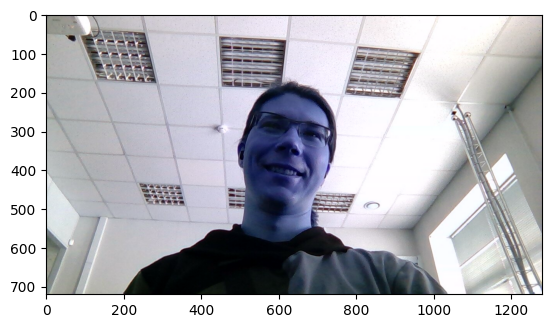

In [4]:
plt.imshow(orig_img)

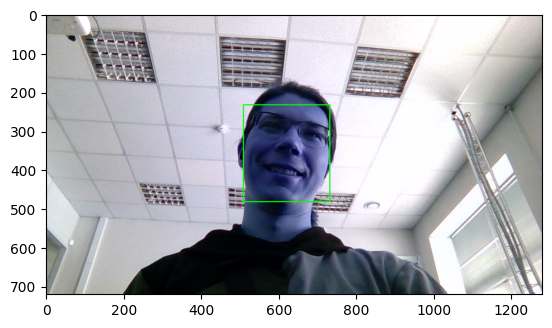

In [22]:
image = cv2.rectangle(orig_img, (x_left, y_top), (x_right, y_bottom), (0,255,0), 2)
plt.imshow(image)

In [45]:
transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
image = cv2.rectangle(orig_img, (x_left, y_top), (x_right, y_bottom), (0,255,0), 2)

image = image[y_top:y_bottom, x_left:x_right,:]
# plt.imshow(image)
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
img = transformations(img)
img = torch.unsqueeze(img, 0)
print(img.size())

torch.Size([1, 3, 224, 224])


In [ ]:
pos_net = stable_hopenetlite.shufflenet_v2_x1_0()  
saved_state_dict = torch.load('deep_head_pose_lite/model/shuff_epoch_120.pkl', map_location="cpu")   
pos_net.load_state_dict(saved_state_dict, strict=False)  
pos_net.eval()

In [46]:
yaw, pitch, roll = pos_net(img)

In [ ]:
idx_tensor = torch.FloatTensor(list(range(66)))

yaw_predicted = F.softmax(yaw)
pitch_predicted = F.softmax(pitch)
roll_predicted = F.softmax(roll)
#  Get continuous predictions in degrees.
yaw_predicted = torch.sum(yaw_predicted.data * idx_tensor) * 3 - 99
pitch_predicted = torch.sum(pitch_predicted.data * idx_tensor) * 3 - 99
roll_predicted = torch.sum(roll_predicted.data * idx_tensor) * 3 - 99

In [52]:
roll_predicted

tensor(12.0691)

In [50]:
import numpy as np

def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):

    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (np.cos(yaw) * np.cos(roll)) + tdx
    y1 = size * (np.cos(pitch) * np.sin(roll) + np.sin(roll) * np.sin(pitch) * np.sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-np.cos(yaw) * np.sin(roll)) + tdx
    y2 = size * (np.cos(pitch) * np.cos(roll) - np.sin(pitch) * np.sin(yaw) * np.sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (np.sin(yaw)) + tdx
    y3 = size * (-np.cos(yaw) * np.sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

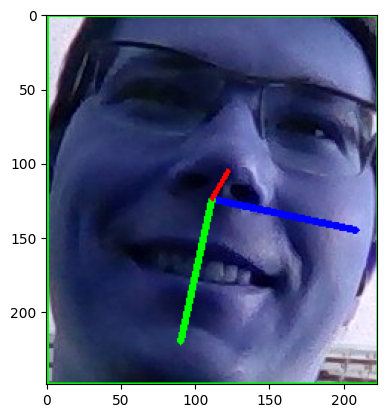

In [51]:
new_image = draw_axis(image, yaw_predicted, pitch_predicted, roll_predicted)
plt.imshow(new_image)

----

In [1]:
import cv2
import os
import mediapipe as mp
import torch
import torch.nn.functional as F
from deep_head_pose_lite import stable_hopenetlite
from torchvision import transforms
from PIL import Image
from mediapipe.tasks import python
from mediapipe.tasks.python.vision.face_landmarker import FaceLandmarkerResult
from mediapipe.tasks.python.vision.hand_landmarker import HandLandmarkerResult
from mediapipe.tasks.python.components.containers.landmark import NormalizedLandmark
from mediapipe.tasks.python import vision
from pprint import pprint
import numpy as np
from typing import List
from tqdm import tqdm
import os

In [3]:
SCRIPT_DIR = '/home/ed-validator-bootcamp'
MODELS_ROOT = os.path.join(SCRIPT_DIR, "models")
SEGMENT_MODEL_PATH = os.path.join(MODELS_ROOT, "selfie_segmenter.tflite")
SAMPLE_IMAGES_ROOT = os.path.join(SCRIPT_DIR, "demo_images")
FACE_SAMPLE = os.path.join(SAMPLE_IMAGES_ROOT, "face_image.jpg")

def init_segmentation_model()-> vision.ImageSegmenter:
    base_options = python.BaseOptions(model_asset_path=SEGMENT_MODEL_PATH)
    options = vision.ImageSegmenterOptions(
        base_options=base_options,
        output_category_mask=True
    )
    segmenter = vision.ImageSegmenter.create_from_options(options)
    return segmenter

In [ ]:
segmenter = init_segmentation_model()

image = mp.Image.create_from_file(FACE_SAMPLE)
viz_image = cv2.imread(FACE_SAMPLE)

segmentation_result = segmenter.segment(image)
category_mask = segmentation_result.category_mask


In [5]:
category_mask = category_mask.numpy_view()
category_mask = category_mask[:, :, np.newaxis].copy() 
category_mask = np.repeat(category_mask, 3, axis=2)

bool_mask = np.array(category_mask, dtype=bool)
bool_mask_flatten = bool_mask[:,:,0].flatten()

result = bool_mask * viz_image

In [8]:
res = []
for chanel in range(3):
    flat_chan = result[:,:,chanel].flatten()
    flat_chan = flat_chan * bool_mask_flatten
    res.append(np.std(flat_chan))

print(res)

[87.20443772190937, 86.70761866599781, 88.98650050639496]


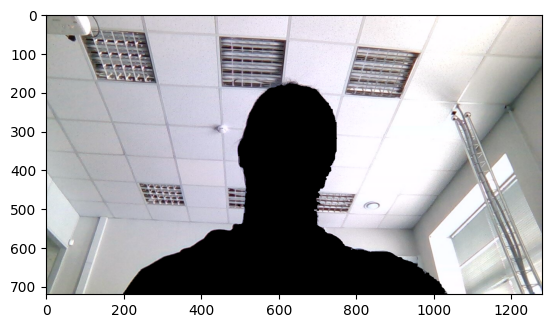

In [78]:
result = bool_mask * viz_image
plt.imshow(result)

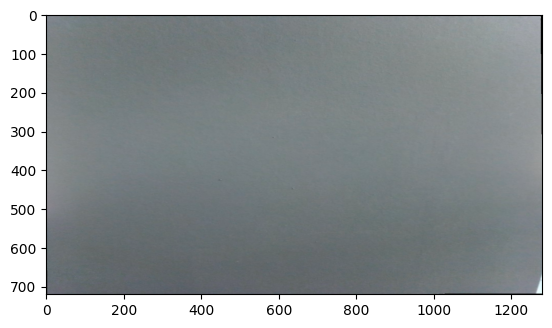

In [10]:
plane = cv2.imread('/home/ed-validator-bootcamp/demo_images/plane_back.jpg')
plt.imshow(plane)

In [16]:
res = []
for chanel in range(3):
    flat_chan = plane[:,:,chanel].flatten()
    res.append(np.std(flat_chan))

print(res)

[14.088947016170192, 14.066245711670318, 13.799218177017462]
